In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn     # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss function
import torch.optim as optim     # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F     # All functions that don't have any parameters
from torch.utils.data import TensorDataset, DataLoader     # Gives easier dataset management and creates mini batchs
import torchvision.transforms as transforms     # Transformations we can perform on our dataset

import warnings
warnings.simplefilter("ignore")

print("PyTorch version " + torch.__version__)

PyTorch version 1.13.1+cu117


In [2]:
from helper_train import train_autoencoder_v1
from helper_data import get_dataloaders_mnist
from helper_train import train_vae_v1, train_vae_v2
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_accuracy
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [3]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
device = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Hyperparameters
RANDOM_SEED = 43
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
NUM_EPOCHS = 100

Device: cuda:0


In [4]:
set_deterministic
set_all_seeds(RANDOM_SEED)

In [5]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
    
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )

    def forward(self, x):
        print(f"ENCODER============")
        x = x.reshape((1, self.seq_len, self.n_features))
        print(f"x reshape: {x.shape}")
        
        x, (_, _) = self.rnn1(x)
        print(f"x of rnn1 : {x.shape}")
        x, (hidden_n, _) = self.rnn2(x)
        print(f"x of rnn2 : {x.shape}")
        print(f"hidden_n of rnn2 : {hidden_n.reshape((self.n_features, self.embedding_dim)).shape}")

        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [6]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=128, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = 2 * input_dim
        self.n_features = n_features
        
        self.linear = nn.Linear(128, 128)

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        print(f"DECODER============")
        x = x.repeat(self.seq_len, self.n_features)
        print(f"x repeat : {x.shape}")
        
        x = x.reshape((self.n_features, self.seq_len, 128))
        print(f"x reshape : {x.shape}")
        
        x = self.linear(x)
        print(f"x linear reshape : {x.shape}")

        x, (hidden_n, cell_n) = self.rnn1(x)
        print(f"x of rnn1 : {x.shape}")
        print(f"hidden_n of rnn1 : {hidden_n.shape}")
        
        x, (hidden_n, cell_n) = self.rnn2(x)
        print(f"x of rnn2 : {x.shape}")
        print(f"hidden_n of rnn2 : {hidden_n.shape}")
        
        x = x.reshape((self.seq_len, self.hidden_dim))
        print(f"x reshape : {x.shape}")

        return self.output_layer(x)

In [7]:
class VAE_LSTM(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=128):
        super(VAE_LSTM, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        
        self.z_mean = torch.nn.Linear(128, 128).to(device)
        self.z_log_var = torch.nn.Linear(128, 128).to(device)
        self.softplus = torch.nn.Softplus() # added
        
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def forward(self, x):
        x = self.encoder(x)
        print(f"encoder xshape: {x.shape}")
        
        mean, std = self.z_mean(x), self.z_log_var(x)
        print(f"mean============")
        print(f"{mean.size(0)=}")
        print(f"{mean.size(1)=}")
        print(f"{mean=}")
        
        print(f"std============")
        print(f"{std=}")
        
        #the softplus function to convert the log variance output from the linear layer to a positive value
        std = self.softplus(std)
        print(f"{std=}")
        
        encoded = self.reparameterize(mean, std)
        print(f"encoded reparameterize: {encoded.shape}")
        
        x = self.decoder(encoded)
        print(f"recon shape: {x.shape}")

        return x, encoded, mean, std

In [8]:
seq_len = 96
n_features = 1

# Create a dummy input
x = torch.randn(1, seq_len, n_features).to(device)

model = VAE_LSTM(seq_len, n_features).to(device)

# Call the model with the input
y, encoded, mean, std = model(x)

# Check the output shape
print("Final Output Shape: ", y.shape)

ENCODER============
x reshape: torch.Size([1, 96, 1])
x of rnn1 : torch.Size([1, 96, 256])
x of rnn2 : torch.Size([1, 96, 128])
hidden_n of rnn2 : torch.Size([1, 128])
encoder xshape: torch.Size([1, 128])
mean============
mean.size(0)=1
mean.size(1)=128
mean=tensor([[-0.0342, -0.0021,  0.0074, -0.0336, -0.0806, -0.0915,  0.0697, -0.0658,
          0.0222,  0.0762,  0.0801, -0.0077, -0.0113, -0.0176,  0.0306,  0.0770,
          0.0639,  0.0825,  0.0499, -0.0722, -0.0330, -0.0486,  0.0635,  0.0096,
         -0.0949, -0.0371, -0.0323, -0.0127,  0.0004, -0.0682, -0.0635,  0.0860,
         -0.0335,  0.0920, -0.0282,  0.0777, -0.0752, -0.0554, -0.0246,  0.0260,
          0.0604, -0.0271,  0.0808, -0.0105,  0.0649, -0.0464,  0.0478,  0.0560,
         -0.0126, -0.0031, -0.0541, -0.0310, -0.0589,  0.0257,  0.0080,  0.0164,
          0.0536,  0.0825,  0.0569, -0.0213,  0.0258, -0.0178,  0.0223,  0.1081,
          0.0148, -0.0396, -0.0652, -0.0772, -0.0328, -0.0519, -0.1005, -0.0740,
          0.

In [9]:
# Modify
class Encoder(nn.Module):

    def __init__(self, batch_size, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.batch_size = batch_size
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim
        
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.2)

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.2)
    
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
        

    def forward(self, x):
        print(f"ENCODER============")
        # x = x.reshape((self.batch_size, self.seq_len, self.n_features))
        print(f"x reshape: {x.shape}")
        x = self.relu1(x)
        x, (_, _) = self.rnn1(x)
        print(f"x of rnn1 : {x.shape}")
        x = self.dropout1(x)
        
        x = self.relu2(x)
        x, (hidden_n, _) = self.rnn2(x)
        print(f"x of rnn2 : {x.shape}")
        print(f"hidden_n of rnn2 : {hidden_n.reshape((self.batch_size, self.embedding_dim)).shape}")
        x = self.dropout2(x)

        return hidden_n.reshape((self.batch_size, self.embedding_dim))
    
class Decoder(nn.Module):

    def __init__(self, batch_size, seq_len, input_dim=128, n_features=1):
        super(Decoder, self).__init__()

        self.batch_size = batch_size
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = 2 * input_dim
        self.n_features = n_features
        
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.2)
        
        self.linear = nn.Linear(128, 128)

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.2)

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        print(f"DECODER============")
        x = x.repeat(self.seq_len, self.n_features)
        print(f"x repeat : {x.shape}")
        
        x = x.reshape((self.batch_size, self.seq_len, 128))
        print(f"x reshape : {x.shape}")
        
        x = self.linear(x)
        print(f"x linear reshape : {x.shape}")
        
        x = self.relu1(x)
        x, (hidden_n, cell_n) = self.rnn1(x)
        print(f"x of rnn1 : {x.shape}")
        print(f"hidden_n of rnn1 : {hidden_n.shape}")
        x = self.dropout1(x)
        
        x = self.relu2(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        print(f"x of rnn2 : {x.shape}")
        print(f"hidden_n of rnn2 : {hidden_n.shape}")
        x = self.dropout2(x)
        
        x = x.reshape((self.batch_size, self.seq_len, self.hidden_dim))
        print(f"x reshape : {x.shape}")

        return self.output_layer(x)

class VAE_LSTM(nn.Module):

    def __init__(self, batch_size, seq_len, n_features, embedding_dim=128):
        super(VAE_LSTM, self).__init__()

        self.encoder = Encoder(batch_size, seq_len, n_features, embedding_dim).to(device)
        
        self.z_mean = torch.nn.Linear(embedding_dim, embedding_dim).to(device)
        self.z_log_var = torch.nn.Linear(embedding_dim, embedding_dim).to(device)
        self.softplus = torch.nn.Softplus() # added
        
        self.decoder = Decoder(batch_size, seq_len, embedding_dim, n_features).to(device)
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        print(f"=====================>{eps.shape}")
        print(f"=====================>{z_mu.shape}")
        
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def forward(self, x):
        batch_size = x.shape[0]
        print(f"batch_size: {batch_size}")
        seq_len = x.shape[1]
        print(f"seq_len: {seq_len}")
        
        x = x.reshape(batch_size, seq_len, -1)
        print(f"xshape before encoder: {x.shape}")
        
        x = self.encoder(x)
        print(f"encoder xshape: {x.shape}")
        
        mean, std = self.z_mean(x), self.z_log_var(x)
        print(f"mean============")
        print(f"{mean.size(0)=}")
        print(f"{mean.size(1)=}")
        print(f"{mean=}")
        
        print(f"std============")
        print(f"{std=}")
        
        #the softplus function to convert the log variance output from the linear layer to a positive value
        std = self.softplus(std)
        print(f"{std=}")
        
        encoded = self.reparameterize(mean, std)
        print(f"encoded reparameterize: {encoded.shape}")
        
        x = self.decoder(encoded)
        print(f"recon shape: {x.shape}")

        return x, encoded, mean, std

In [10]:
batch_size = 32
seq_len = 96
n_features = 1

# Create a dummy input
x = torch.randn(batch_size, seq_len, n_features).to(device)

model = VAE_LSTM(batch_size, seq_len, n_features).to(device)

# Call the model with the input
y, encoded, mean, std = model(x)

# Check the output shape
print("Final Output Shape: ", y.shape)

batch_size: 32
seq_len: 96
xshape before encoder: torch.Size([32, 96, 1])
ENCODER============
x reshape: torch.Size([32, 96, 1])
x of rnn1 : torch.Size([32, 96, 256])
x of rnn2 : torch.Size([32, 96, 128])
hidden_n of rnn2 : torch.Size([32, 128])
encoder xshape: torch.Size([32, 128])
mean============
mean.size(0)=32
mean.size(1)=128
mean=tensor([[-0.0263,  0.0109, -0.0206,  ..., -0.0853, -0.0405,  0.0914],
        [-0.0229,  0.0157, -0.0220,  ..., -0.0845, -0.0400,  0.0881],
        [-0.0277,  0.0097, -0.0247,  ..., -0.0839, -0.0391,  0.0974],
        ...,
        [-0.0285,  0.0091, -0.0200,  ..., -0.0855, -0.0386,  0.0922],
        [-0.0241,  0.0108, -0.0196,  ..., -0.0834, -0.0414,  0.0910],
        [-0.0243,  0.0119, -0.0200,  ..., -0.0878, -0.0394,  0.0947]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
std============
std=tensor([[-0.0528,  0.0325,  0.0658,  ..., -0.0405, -0.0426,  0.0162],
        [-0.0498,  0.0323,  0.0672,  ..., -0.0421, -0.0440,  0.0180],
        [-0.0516,

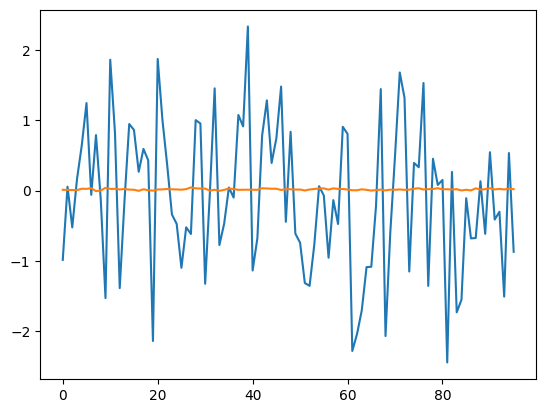

In [11]:
# Plot
plt.plot(x[0].cpu())
plt.plot(y[0].detach().cpu())

## TRY TO BATCH_SIZE

In [12]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim
        
        self.relu1 = nn.ReLU()

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=2,
          batch_first=True,
          dropout=0.2
        )
    
        self.relu2 = nn.ReLU()
        
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=2,
          batch_first=True,
          dropout=0.2
        )

    def forward(self, x):
        print(f"ENCODER============")
        x = self.relu1(x)
        print(f"x before rnn1: {x.shape}")
        
        x, (_, _) = self.rnn1(x)
        print(f"x of rnn1 : {x.shape}")
        
        x = self.relu2(x)
        x, (hidden_n, _) = self.rnn2(x)
        print(f"x of rnn2 : {x.shape}")
        print(f"hidden_n of rnn2 : {hidden_n.reshape((-1, self.embedding_dim)).shape}")
        
        # use hidden_n when num_layer=1 
        
        # Use only the last layer's hidden state, with shape [batch_size, hidden_dim]
        hidden_n_last = hidden_n[-1, :, :]
        print(f"hidden_n_last : {hidden_n_last.shape}")
        
        # use hidden_n_last when num_layer=2


        return hidden_n_last

class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=128, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = 2 * input_dim
        self.n_features = n_features
        
        self.linear = nn.Linear(128, 128)
        
        self.relu1 = nn.ReLU()

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=2,
          batch_first=True,
          dropout=0.2
        )
        
        self.relu2 = nn.ReLU()

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=2,
          batch_first=True,
          dropout=0.2
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        print(f"DECODER============")
        x = x.repeat(1, self.seq_len).reshape(-1, self.seq_len, self.input_dim)
        print(f"x repeat : {x.shape}")
        
        x = self.linear(x)
        print(f"x linear : {x.shape}")
        
        x = self.relu1(x)
        x, (hidden_n, cell_n) = self.rnn1(x)
        print(f"x of rnn1 : {x.shape}")
        print(f"hidden_n of rnn1 : {hidden_n.shape}")
        
        x = self.relu2(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        print(f"x of rnn2 : {x.shape}")
        print(f"hidden_n of rnn2 : {hidden_n.shape}")
        
        x = x.reshape(-1, self.seq_len, self.hidden_dim)
        print(f"x reshape : {x.shape}")

        return self.output_layer(x)

class VAE_LSTM(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=128):
        super(VAE_LSTM, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        
        self.z_mean = torch.nn.Linear(128, 128).to(device)
        self.z_log_var = torch.nn.Linear(128, 128).to(device)
        self.softplus = torch.nn.Softplus()
        
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def forward(self, x):
        x = self.encoder(x)
        print(f"xshape before encoder: {x.shape}")
        
        mean, std = self.z_mean(x), self.z_log_var(x)
        print(f"mean============")
        print(f"{mean.size(0)=}")
        print(f"{mean.size(1)=}")
        print(f"{mean.shape}")
        print(f"{mean=}")
        
        print(f"std============")
        print(f"{std.shape}")
        print(f"{std=}")
        std = self.softplus(std)
        print(f"{std=}")
        
        encoded = self.reparameterize(mean, std)
        print(f"encoded reparameterize: {encoded.shape}")
        print(f"{encoded=}")
        x = self.decoder(encoded)
        print(f"recon shape: {x.shape}")

        return x, encoded, mean, std


In [13]:
# Test the model
import torch
from torch.utils.data import Dataset, DataLoader

class RandomDataset(Dataset):
    def __init__(self, batch_size, seq_len, n_features, num_samples=1000):
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.n_features = n_features
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.randn(self.seq_len, self.n_features)

# Define your dataset and DataLoader
batch_size = 32
seq_len = 96
n_features = 1
num_samples = 1000

random_dataset = RandomDataset(batch_size, seq_len, n_features, num_samples)
dataloader = DataLoader(random_dataset, batch_size=batch_size, shuffle=True)

# Initialize your model
model = VAE_LSTM(seq_len, n_features).to(device)

# Test your model on a batch of data
for batch_idx, x in enumerate(dataloader):
    x = x.to(device)
    y, encoded, mean, std = model(x)
    print(f"Batch {batch_idx + 1} Output Shape: {y.shape}")
    
    # You can break the loop after the first batch if you just want to test one batch
    break


ENCODER============
x before rnn1: torch.Size([32, 96, 1])
x of rnn1 : torch.Size([32, 96, 256])
x of rnn2 : torch.Size([32, 96, 128])
hidden_n of rnn2 : torch.Size([64, 128])
hidden_n_last : torch.Size([32, 128])
xshape before encoder: torch.Size([32, 128])
mean============
mean.size(0)=32
mean.size(1)=128
torch.Size([32, 128])
mean=tensor([[ 0.0168, -0.0008,  0.0217,  ...,  0.0562,  0.0391, -0.0929],
        [ 0.0174, -0.0066,  0.0230,  ...,  0.0560,  0.0415, -0.0948],
        [ 0.0164, -0.0036,  0.0226,  ...,  0.0560,  0.0413, -0.0945],
        ...,
        [ 0.0183, -0.0049,  0.0233,  ...,  0.0548,  0.0388, -0.0915],
        [ 0.0143, -0.0037,  0.0267,  ...,  0.0583,  0.0399, -0.0894],
        [ 0.0192,  0.0018,  0.0221,  ...,  0.0546,  0.0392, -0.0949]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
std============
torch.Size([32, 128])
std=tensor([[-0.0157,  0.0358, -0.0782,  ..., -0.0033, -0.0048,  0.0635],
        [-0.0144,  0.0363, -0.0808,  ..., -0.0055, -0.0029,  0.0661]

In [14]:
model

VAE_LSTM(
  (encoder): Encoder(
    (relu1): ReLU()
    (rnn1): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.2)
    (relu2): ReLU()
    (rnn2): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.2)
  )
  (z_mean): Linear(in_features=128, out_features=128, bias=True)
  (z_log_var): Linear(in_features=128, out_features=128, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
  (decoder): Decoder(
    (linear): Linear(in_features=128, out_features=128, bias=True)
    (relu1): ReLU()
    (rnn1): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2)
    (relu2): ReLU()
    (rnn2): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

# AE

In [32]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim
        
        self.relu1 = nn.ReLU()

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True,
          dropout=0.2
        )
        
        self.relu2 = nn.ReLU()
    
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True,
          dropout=0.2
        )
        
    def forward(self, x):
        print(f"ENCODER============")
        x = self.relu1(x)
        print(f"x before rnn1: {x.shape}")

        x, (_, _) = self.rnn1(x)
        print(f"x of rnn1 : {x.shape}")
        
        x = self.relu2(x)
        x, (hidden_n, _) = self.rnn2(x)
        print(f"x of rnn2 : {x.shape}")
        print(f"hidden_n of rnn2 : {hidden_n.reshape((-1, self.embedding_dim)).shape}")

        return hidden_n.reshape((-1, self.embedding_dim))

class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=128, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = 2 * input_dim
        self.n_features = n_features
        
        self.relu1 = nn.ReLU()

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True,
          dropout=0.2
        )
        
        self.relu2 = nn.ReLU()

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True,
          dropout=0.2
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)
        
    def forward(self, x):
        print(f"DECODER============")
        x = x.repeat(1, self.seq_len).reshape(-1, self.seq_len, self.input_dim)
        print(f"x repeat : {x.shape}")
        
        x = self.relu1(x)
        x, (hidden_n, cell_n) = self.rnn1(x)
        print(f"x of rnn1 : {x.shape}")
        print(f"hidden_n of rnn1 : {hidden_n.shape}")
        
        x = self.relu2(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        print(f"x of rnn2 : {x.shape}")
        print(f"hidden_n of rnn2 : {hidden_n.shape}")
        x = x.reshape(-1, self.seq_len, self.hidden_dim)
        print(f"x reshape : {x.shape}")

        return self.output_layer(x)

class AE_LSTM(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=128):
        super(AE_LSTM, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
     
    def forward(self, x):
        print(f"AE_LSTM============")
        encoded = self.encoder(x)
        print(f"x after encoder : {encoded.shape}")
        x = self.decoder(encoded)
        print(f"recon shape: {x.shape}")

        return x, encoded

In [34]:
# Test the model
import torch
from torch.utils.data import Dataset, DataLoader

class RandomDataset(Dataset):
    def __init__(self, batch_size, seq_len, n_features, num_samples=1000):
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.n_features = n_features
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.randn(self.seq_len, self.n_features)

# Define your dataset and DataLoader
batch_size = 64
seq_len = 96
n_features = 1
num_samples = 1000

random_dataset = RandomDataset(batch_size, seq_len, n_features, num_samples)
dataloader = DataLoader(random_dataset, batch_size=batch_size, shuffle=True)

# Initialize your model
model = AE_LSTM(seq_len, n_features).to(device)

# Test your model on a batch of data
for batch_idx, x in enumerate(dataloader):
    x = x.to(device)
    y, encoded = model(x)
    print(f"Batch {batch_idx + 1} Output Shape: {y.shape}")
    
    # You can break the loop after the first batch if you just want to test one batch
    break


AE_LSTM============
ENCODER============
x before rnn1: torch.Size([64, 96, 1])
x of rnn1 : torch.Size([64, 96, 256])
x of rnn2 : torch.Size([64, 96, 128])
hidden_n of rnn2 : torch.Size([64, 128])
x after encoder : torch.Size([64, 128])
DECODER============
x repeat : torch.Size([64, 96, 128])
x of rnn1 : torch.Size([64, 96, 128])
hidden_n of rnn1 : torch.Size([1, 64, 128])
x of rnn2 : torch.Size([64, 96, 256])
hidden_n of rnn2 : torch.Size([1, 64, 256])
x reshape : torch.Size([64, 96, 256])
recon shape: torch.Size([64, 96, 1])
Batch 1 Output Shape: torch.Size([64, 96, 1])
